<a href="https://colab.research.google.com/github/BI-DS/EBA-3530/blob/main/Lecture_5/sequential_and_lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Sequential feature selection and Lasso

1) Simulate 500 observations with 10 differente covariates each. For simplicity assume that the covariates are generated by the multivarite normal distribution $x \sim \mathcal{N}_d(0,1)$, where $d=10$ is the dimensionality of $x$.

In [2]:
# @title 1) simulate x
# Number of observations
N = 500

# Numbers of predictors
p = 10

# Generate some random x's
x = np.random.normal(size=(N,p))

# give some names (not really needed)
names = pd.DataFrame(['feature_'+str(i) for i in range(p)])

2) Assume that the true data generating process for the dependent variable $y$ is
$$
y = \beta_1x_1+\beta_2x_2+\beta_3x_3+\beta_4x_4+\epsilon,
$$
where $\beta_1=0.5$, $\beta_2=1$, $\beta_3=-5$, $\beta_4=5$, and $\epsilon \sim \mathcal{N}(0,1)$, and $x_i$ for $i=1,\cdots,4$ are the first four covariates generated in exercise 1).

In [31]:
# @title 2) simulate y

# True variance in regression
sigma2 = 1

# Define the relevant (true) x's
true_x_idx = [0, 1, 2, 3]
true_B = np.array([0.5, 1, -5, 5]).reshape((1,4))

# Generate y
y = np.dot(x[:,true_x_idx],np.transpose(true_B)) + \
              np.random.normal(size=(N,1))*np.sqrt(sigma2)

## Forward feature selection
It is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the `n_features_to_select` parameter.


In [6]:
linear_base = LinearRegression()
forward_selection = sfs(estimator=linear_base, n_features_to_select=6,\
                direction='forward', scoring='neg_mean_squared_error').fit(x,y)
print("Features selected by forward sequential selection: {}".\
      format(names[forward_selection.get_support()]))

Features selected by forward sequential selection:            0
0  feature_0
1  feature_1
2  feature_2
3  feature_3
7  feature_7
8  feature_8


3) Now fit an OSL model only using the covariates selected by the forward feature selection approach plus a constant term

In [11]:
# @title 3) OSL with features selected with forward feature selection

# only the features selected by the forward approach
x_fs = x[:,forward_selection.get_support()]
forward_lr = sm.OLS(y,sm.add_constant(x_fs)).fit()
print(forward_lr.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     4360.
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        07:42:16   Log-Likelihood:                -709.00
No. Observations:                 500   AIC:                             1432.
Df Residuals:                     493   BIC:                             1462.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0266      0.045      0.588      0.5

## Backward feature selection
It follows the same idea as the forward approach, but works in the opposite direction: instead of starting with no feature and greedily adding features, it starts with all the features and greedily remove features from the set. The `direction` parameter in the function controls whether forward or backward is used.



In [ ]:
backward_selection = sfs(estimator=linear_base, n_features_to_select=6,\
                direction='backward', scoring='neg_mean_squared_error').fit(x,y)
print("Features selected by backward sequential selection: {}".\
      format(names[backward_selection.get_support()]))

4) Now fit an OSL model only using the covariates selected by the backward feature selection approach plus a constant term

In [ ]:
# @title 4) OSL with features selected with backward feature selection

# only the features selected by the backward approach
x_bs = x[:,backward_selection.get_support()]
backward_lr = sm.OLS(y,sm.add_constant(x_bs)).fit()
print(backward_lr.summary())

**Note:** In general, forward and backward selection do not yield equivalent results. Also, one may be much faster than the other depending on the requested number of selected features: if we have 10 features and ask for 7 selected features, forward selection would need to perform 7 iterations while backward selection would only need to perform 3.

## Least Absolute Shrinkage and Selection Operator (LASSO)
The implementation of LASSO in `sklearn` calls the $\lambda$ the parameter $\alpha$!

5) fit a LASSO regression model using $\lambda=1$ and the $x$ and $y$ variables from exercises 1) and 2). Print the variables selected by the LASSO model and their estimated parameters.

In [26]:
#@title 5) LASSO model $\lambda=1$

# For LASSO, select the penalty term L1_wt to be 1
lassoreg = Lasso().fit(x,y)
lasso_coeff = []
lasso_coeff.extend(lassoreg.intercept_)
lasso_coeff.extend(lassoreg.coef_[lassoreg.coef_!=0])
print("Features selected by LASSO:\n{}\nwith coefficients {}".\
      format('intercept\n'+names[lassoreg.coef_!=0].to_string(index=False,\
            header=False), np.round(lasso_coeff,4)))

Features selected by LASSO:
intercept
feature_1
feature_2
feature_3
with coefficients [ 0.0375  0.0397 -4.0839  3.9595]


**Cross-valitation with LASSO**

6) Cross-validate $\lambda$ in the grid [1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10] for $k=5$. For each $\lambda$ values, print the average mean squared error and its standard deviation.

In [27]:
# @title 6) $\lambda$ cross-validation

# Choose different values for the hyperparameter alpha
alphas = [1e-15, 1e-10, 1e-8, 1e-5, 1e-4, 1e-3, 1e-2, 1, 5, 10]

# for each alpha value, we conduct a 5-folds CV
cv = 5

# save mean squared errors in a matrix
all_scores = np.zeros((len(alphas),cv))

for i,alpha in enumerate(alphas):
  kfolds = KFold(n_splits=cv, shuffle=True)
  all_scores[i,:] = cross_val_score(Lasso(alpha=alpha, max_iter=10000),x,y,cv=kfolds,\
                           scoring='neg_mean_squared_error')

print('Average mse {} \n with std {}'.\
      format(np.round(-1*np.mean(all_scores,axis=1),4),\
             np.round(np.std(all_scores,axis=1),4)))


Average mse [ 1.052   1.035   1.0599  1.0476  1.0688  1.0394  1.0467  4.3062 50.1571
 54.1754] 
 with std [ 0.1263  0.131   0.1422  0.1159  0.1247  0.1302  0.1682  0.6879  8.5035
 11.686 ]


7) make a plot that shows the average mse together with the standard deviations from exercise 6)

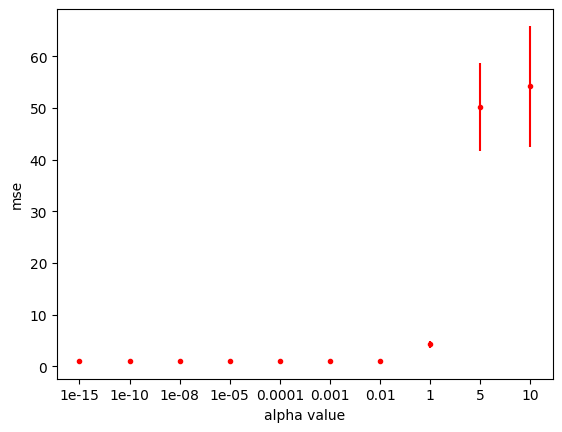

In [28]:
#@title 7) plot

avg_mse = -1*np.mean(all_scores,axis=1)
std_mse = np.std(all_scores,axis=1)
plt.errorbar(range(10),avg_mse, yerr=std_mse, fmt='.', color='r')
plt.xticks(range(10), [str(a) for a in alphas])
plt.xlabel('alpha value')
plt.ylabel('mse')
plt.show()

**Effect of the hyperparameter λ on $\beta$**

8) Select 3 $\lambda$ values from exercise 6), fit a LASSO model for each value using all 10 covariates, and calcualte the sum of squared residuals (ssr). Print a table summarizing $\lambda$, ssr, and all $\beta$ parameters estimated by LASSO.

In [34]:
# @title 8) LASSO, ssr, and estimated parameters

# create a LASSO model for different lambda values
# and fit the model
lasso_1 =  Lasso(alpha=alphas[0]).fit(x,y)
lasso_2 =  Lasso(alpha=alphas[5]).fit(x,y)
lasso_3 =  Lasso(alpha=alphas[7]).fit(x,y)

# get predicted values based on the fitted model
y_pred1 = lasso_1.predict(x)
y_pred2 = lasso_2.predict(x)
y_pred3 = lasso_3.predict(x)

# get sum of squared residuals (rss)
rss1 = np.round(np.sum((y_pred1 -y)**2),1)
rss2 = np.round(np.sum((y_pred2 -y)**2),1)
rss3 = np.round(np.sum((y_pred3 -y)**2),1)

# create a list with: i) rss and ii) model coefficients
results1 = [rss1]
results1.extend(np.round(lasso_1.intercept_.tolist(),3))
results1.extend(np.round(lasso_1.coef_.tolist(),3))
results2 = [rss2]
results2.extend(np.round(lasso_2.intercept_.tolist(),3))
results2.extend(np.round(lasso_2.coef_.tolist(),3))
results3 = [rss3]
results3.extend(np.round(lasso_3.intercept_.tolist(),3))
results3.extend(np.round(lasso_3.coef_.tolist(),3))

# create a data frame for easy visualization of retults
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(p)]
ind = ['lambda_%.2g'%alphas[i] for i in [0,5,7]]
matrix_lasso = pd.DataFrame(index=ind, columns=col)

# just append the results row-wise
matrix_lasso.iloc[0,:] = results1
matrix_lasso.iloc[1,:] = results2
matrix_lasso.iloc[2,:] = results3
print(matrix_lasso)


                   rss intercept coef_x_0 coef_x_1 coef_x_2 coef_x_3 coef_x_4  \
lambda_5.5  13622963.6     0.377      0.0      0.0     -0.0      0.0     -0.0   
lambda_3.9  14517567.1     0.258      0.0      0.0   -1.469    1.116     -0.0   
lambda_3.4  15289254.1      0.21      0.0      0.0   -1.925    1.633     -0.0   

           coef_x_5 coef_x_6 coef_x_7 coef_x_8 coef_x_9  
lambda_5.5     -0.0      0.0      0.0     -0.0     -0.0  
lambda_3.9     -0.0      0.0      0.0     -0.0     -0.0  
lambda_3.4     -0.0      0.0      0.0     -0.0     -0.0  


Alternatively use `LassoCV` that saves the best model in the CV.

The optimal lambda is 0.0385:


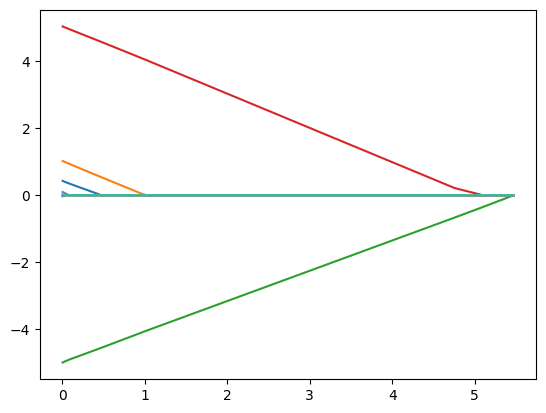

In [33]:
# define the LassoCV object
lasso_cv = LassoCV(cv=cv, fit_intercept=True).fit(x,y.ravel())
print('The optimal lambda is {:.4f}:'.format(lasso_cv.alpha_))

# compute the path
[alphas,weights,c] = lasso_cv.path(x, y.ravel())

# plot coeffs as a function of alpha
fig = plt.figure()
plt.plot(alphas, weights.T)
plt.show()